# FACE MASK IMAGE RECOGNITION
BY: MEHER MANKIKAR 07/10/2020
Given an image of a person, the neural net learns to detect whether the person is wearing a facial covering or not. 

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask/facemask.txt
/kaggle/input/face-mask/image001.jpg
/kaggle/input/no-face-mask/nofacemask.txt


In [6]:
from fastai import *
from fastai.vision import *

# DOWNLOAD IMAGES FROM GOOGLE AND CREATE DATASETS
Two classes of images were downloaded for training: images of individuals wearing face masks and images of individuals without face masks.

In [7]:
classes = ['face-mask', 'no-face-mask']

In [8]:
folder = 'face-mask'
file = 'facemask.txt'

In [9]:
path = Path('/Users/mehermankikar/Desktop/KaggleData')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)


In [10]:
path.ls()

[PosixPath('/Users/mehermankikar/Desktop/KaggleData/face-mask')]

In [11]:
!cp ../input/* {path}/*


cp: -r not specified; omitting directory '../input/face-mask'
cp: -r not specified; omitting directory '../input/no-face-mask'


In [12]:
download_images('../input/face-mask/facemask.txt', dest, max_pics=200)
##../input/facemask.txt

In [13]:
folder = 'no-face-mask'
file = 'nofacemask.txt'

In [14]:
path = Path('/Users/mehermankikar/Desktop/KaggleData')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [15]:
path.ls()

[PosixPath('/Users/mehermankikar/Desktop/KaggleData/face-mask'),
 PosixPath('/Users/mehermankikar/Desktop/KaggleData/no-face-mask')]

In [16]:
download_images('../input/no-face-mask/nofacemask.txt', dest, max_pics=200)
##../input/nofacemask.txt

In [17]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [18]:
data.classes

['face-mask', 'no-face-mask']

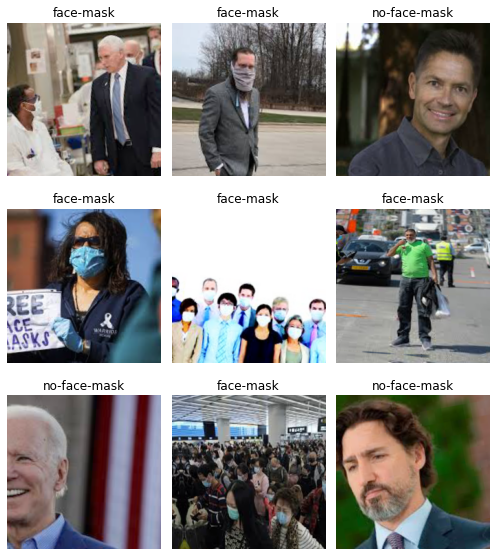

In [19]:
data.show_batch(rows=3, figsize=(7,8))

In [20]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['face-mask', 'no-face-mask'], 2, 320, 80)

# TRAIN MODEL
Using a convolutional neural network.

In [21]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [22]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.983063,1.344173,0.312500,01:10
1,0.673679,0.253466,0.062500,01:09
2,0.500624,0.216880,0.062500,01:07
3,0.412252,0.198138,0.062500,01:06


In [23]:
learn.save('stage-1')

In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(2, max_lr=slice(3e-6,3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.301637,0.186620,0.062500,01:34
1,0.269434,0.184848,0.062500,01:35


In [27]:
learn.save('stage-2')

# INTERPRETATION

In [28]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (320 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
face-mask,face-mask,face-mask,face-mask,face-mask
Path: /Users/mehermankikar/Desktop/KaggleData;

Valid: LabelList (80 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
no-face-mask,no-face-mask,face-mask,no-face-mask,face-mask
Path: /Users/mehermankikar/Desktop/KaggleData;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

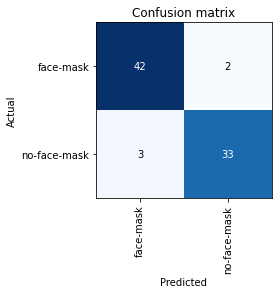

In [30]:
interp.plot_confusion_matrix()

# REMOVING ERROR

In [31]:
from fastai.widgets import *

In [ ]:
db = (ImageList.from_folder(path)
                    .split_none()
                    .label_from_folder()
                    .transform(get_transforms(), size = 224)
                    .databunch()
     )

In [ ]:
learn_clean = cnn_learner(db, models.resnet34, metrics = error_rate)
learn_clean.load('stage-2')

In [ ]:
ds, idxs = DatasetFormatter.from_toplosses(learn_clean)

In [ ]:
ImageCleaner(ds, idxs, path)

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learn_clean)

In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

* # TESTING MODEL****

In [32]:
learn.export()

In [33]:
defaults.device = torch.device('cpu')

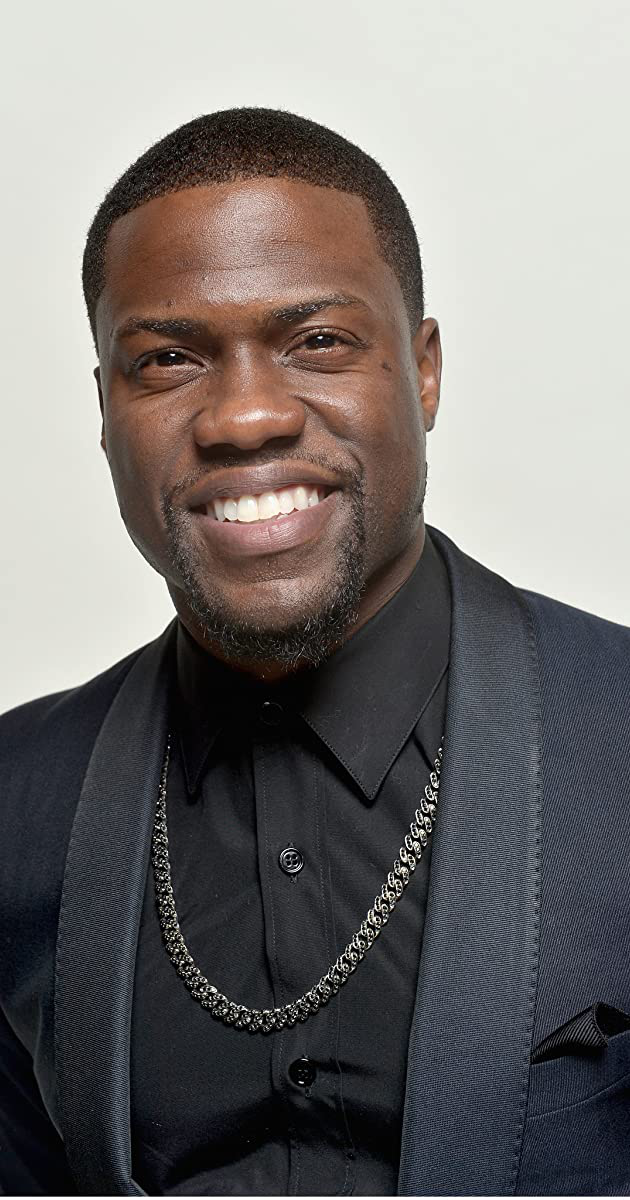

In [34]:
img = open_image('../input/face-mask/image001.jpg')
img

In [35]:
classes = ['face-mask', 'no-face-mask']

In [36]:
data2 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [37]:
learn = create_cnn(data2, models.resnet34).load('stage-2')

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [40]:
pred_class,pred_idx,outputs = learn.predict(img)

In [41]:
pred_class

Category tensor(1)